In [1]:
import numpy as np
import scipy
import pickle
import time
import tqdm
import h5py
import matplotlib.pyplot as plt

# Params

In [2]:
def params(x):
    """
    Expects
     x = {'fa':..., eta_PQ' : ...}
    or something like
     x = {'fa':..., 'T' : ..}
    and will spit back dictionary containing everything you would ever want. 
    """
    
    to_return = {}
    if 'eta_PQ' in x.keys():
        #print('huh')
        x['T'] = (45/(4*np.pi**3*81))**(1/4)*np.sqrt(x['fa'])/x['eta_PQ']
        #print((45/(4*np.pi**3*81))**(1/4),np.sqrt(x['fa'])/x['eta_PQ'],x['T'])
    elif 'T' in x.keys():
        x['eta_PQ'] = (45/(4*np.pi**3*81))**(1/4)*np.sqrt(x['fa'])/x['T']
    else:
        raise NotImplemented
    
    x['H'] = np.sqrt(4*np.pi**3/45)*(81**(1/2))*x['T']**2
    x['t'] = np.sqrt(45/(16*np.pi**3))*(81**(-1/2))
    return x

# Evolve Utils

In [3]:
def RK4(f,t,y,h):
    k1 = f(t,y)
    k2 = f(t+h/2,y+h*k1/2)
    k3 = f(t+h/2,y+h*k2/2)
    k4 = f(t+h,y+h*k3)
    return y + (1/6)*(k1+2*k2+2*k3+k4)*h

def grad(field,dir,order,N):
    """
    take derivative of a field, in a specific direction,
    with some number of points included (stencil number)
    This is a cheap-imitation of something that would use non-axis points 
    https://web.media.mit.edu/~crtaylor/calculator.html
    Probably thats what they meant by seven-point stencil though, the (2,3) scheme I wrote below

    Inputs:
        field: real numpy array
        dir: axis to compute
        order: order of derivative to compute
        N: number of points to include
    """
    
    if (order,N) == (2,3):
        return (np.roll(field,-1,axis=dir) + \
               -2*np.roll(field,-1,axis=dir) + \
               np.roll(field,1,axis=dir))
    if (order,N) == (2,7):
        return (2*np.roll(field,-3,axis=dir) + \
               -27*np.roll(field,-2,axis=dir) + \
               270*np.roll(field,-1,axis=dir) + \
               -490*field + \
               270*np.roll(field,1,axis=dir) + \
               -27*np.roll(field,2,axis=dir) + \
               2*np.roll(field,3,axis=dir))/180
    else:
        print(order,N)
        raise NotImplementedError

def rescaled_nabla(field,a,N=3):
    """
    take rescaled nabla^2 of a field (defined under (S8))
    scale is "a"
    
    Inputs:
        field: 2 x N x N (x N)
    """
    n_space = len(field.shape) - 1
    to_return = np.zeros(field.shape)
    for i in range(1,n_space + 1):
        to_return = to_return + grad(field,i,2,N)
    #print('huh',a,np.sum(np.abs(to_return)),np.sum(field))
    return to_return/(a**2)

def PQ_epoch_diff(eta,field,fieldp,c,a,fa,lamb=1,debug=False):
    """
    (S9) and (S10)
    y'' = f(t,y,y'), this is that function f. (in the PQ epoch)
    a:  dimensionless "Lattice spacing" (old: L_phys (in units of H1) / L_lat (number of sites))
    c : T1**2/3fa**2
    """
    A = -(2/eta)*fieldp 
    B = rescaled_nabla(field,a*eta/fa)
    C = -lamb*field*((eta**2)*(np.repeat(np.expand_dims(np.sum(field**2,axis=0),0),2,0) - 1) + c)
    #print(np.sum(A),np.sum(np.abs(B)),np.sum(C))
    return A + B + C

def earlyQCD_epoch_diff(eta,field,fieldp,scale,etac,lamb=5504,n=6.68,debug=False):
    A = -(2/eta)*fieldp 
    B = rescaled_nabla(field,scale)
    C = -lamb*field*(eta**2)*(np.repeat(np.expand_dims(np.sum(field**2,axis=0),0),2,0) - 1)
    D0 = (min(eta,etac)**n)*(eta**2)*(np.sum(field**2,axis=0)**(-3/2))
    D1 = -field[1]**2; D2 = field[0]*field[1]
    D = np.vstack((D1/D0,D2/D0))
    return A + B + C + D
    
def lateQCD_epoch_diff():
    pass

# Thermal

In [4]:
def thermal(shape,
            c, 
            a,
            eta_PQ,
            fa,
            lamb=1,
            kmax=10):
    '''
    a : lattice
    '''
    assert type(shape) is tuple
    p = params({'eta_PQ': eta_PQ, 'fa' : fa})
    print(p['T'],p['eta_PQ'])
    
    #Easiest to initialize lattice momenta
    k2_lat = np.sum((np.sin(2*np.pi*(np.indices(shape).T/np.array(shape).T).T)**2),axis=0)
    if (p['T']**2)/3 - fa**2 < 0:
        print('HUH?',p['T'],fa/np.sqrt(3))
        raise
    wk = np.sqrt(k2_lat/((a*eta_PQ/fa)**2) + lamb*((p['T']**2)/3 - fa**2))
    nk = 1/(np.exp(wk/p['T']) - 1)
    
    # fill whole array with Gaussian dist
    field   = np.random.normal(0,np.sqrt((nk/wk)*np.prod(shape)*((a*eta_PQ/fa)**3)),(2,)+shape)
    field_p = np.random.normal(0,np.sqrt(nk*wk*np.prod(shape)*((a*eta_PQ/fa)**3)),(2,)+shape)

    # mask out with zeros
    dist = np.sum([np.min(np.array([x**2,(shape[i]-x)**2]),axis=0) for i,x in enumerate(np.indices(shape))],axis=0)
    field[0]   = np.where(dist < kmax**2, field[0], 0)
    field[1]   = np.where(dist < kmax**2, field[1], 0)
    field_p[0] = np.where(dist < kmax**2, field_p[0], 0)
    field_p[1] = np.where(dist < kmax**2, field_p[1], 0)

    # Inverse Fourier Transform!
    field = np.fft.irfftn(field,shape)/fa
    field_p = np.fft.irfftn(field_p,shape)/fa

    # return psi not phi fields
    # including jacobian factor from dt to d eta
    return np.vstack((field,field_p * eta_PQ * fa))

In [971]:
f_fp = thermal((100,100,100),
               c = 0.1343813934716645,
               a = 0.25,
               eta_PQ = 0.1,
               fa = 1,
               kmax=20)

2.587047908831702 0.1


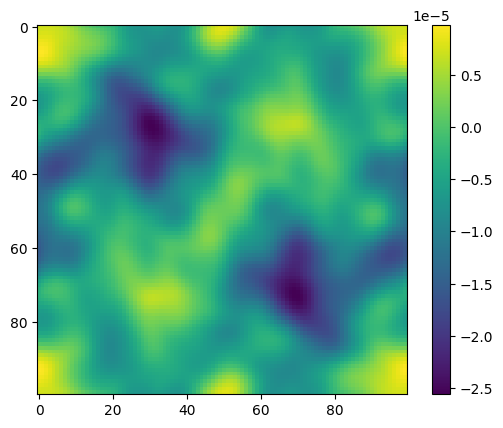

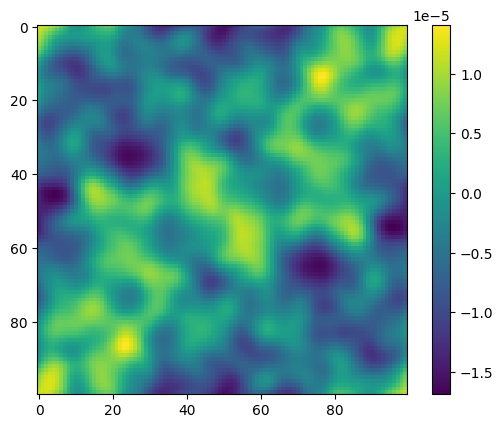

In [972]:
plt.imshow(f_fp[0][0])
plt.colorbar()
plt.show()

plt.imshow(f_fp[2][0])
plt.colorbar()
plt.show()

# Evolve

In [1033]:
def evolve_PQ(shape,
              fa, 
              init_field, 
              init_fieldp, 
              etaini,
              deta, 
              Nstep,
              a,
              stage,
              name=None,
              logdir=None,
              tolog=[],
              flush=100,
              debug=False):
    """
    Evolution in the PQ epoch

    Inputs
               shape : shape of spatial dims
                  fa : in units of m_planck
          init_field : fn that takes shape and spits out an initial config
          init_field : fn that takes shape and spits out an initial config'
              etaini : starting eta
                deta : d_eta
               Nstep : how many steps
                name : name of logfile
              logdir : where to save logfile
               tolog : list containing [("name",lambda f_fp: ..., how often to log this thing, shape of the thing, dtype),...]
               flush : how often to flush the logs
               debug : whether to print out semi-useless debug statements
    """
    
    #gstar = 81
    T1 = np.sqrt(45*fa/(4*np.pi**3))*(81)**(-1/4)
    c = T1**2/(3*fa**2)
    print(f'c:{c}')
    print(f'Transition expected at eta = {(5/(4*(np.pi**3)*81))**(1/4)/(fa**(1/2))}')
    
    if init_field is None:
        y_yp = thermal(shape,c,a,etaini,fa)
        print(y_yp.shape)
    else:
        field    = init_field(shape)            #Init field
        fieldp   = init_fieldp(shape)           #and its derivative
        y_yp     = np.vstack((field,fieldp))    #Stackem
        
    eta      = etaini                       #initial eta
    for i in tqdm.tqdm(range(Nstep)):
        if debug:
            print("running",i,np.average(np.abs(y_yp)))
            time.sleep(1)

        if i%flush == 0:
            logfile = h5py.File(f'{logdir}/{name}_{i//flush}.hdf5', 'w')
            datasets = []
            for x in tolog:
                datasets.append(logfile.create_dataset(x[0], (flush//x[2]+1,) + x[3], x[4]))

        for j,x in enumerate(tolog):
            if i%x[2] == 0:
                datasets[j][(i%flush)//x[2]] = x[1](y_yp)

        if i%flush == flush - 1:
            logfile.flush()
            logfile.close()
        
        if stage == 'PQ':
            y_yp = RK4(lambda eta,y_yp : \
                        np.vstack((y_yp[2:],PQ_epoch_diff(eta,y_yp[:2],y_yp[2:],c,a,fa,debug=debug))),
                   eta,y_yp,deta)
        elif stage == 'earlyQCD':
            raise NotImplemented
        
        eta += deta

    return 

In [1077]:
f.close()
evolve_PQ(shape=(100,100,100),
          fa=1e-1,
          init_field=None,
          init_fieldp=None,
          etaini=0.01,
          deta=0.001,
          Nstep=100000,
          a=0.25,
          stage='PQ',
          name='test',
          logdir='/Users/joshlin/axion_cosmo/notebooks/misc',
          tolog=[("field",lambda f_fp:f_fp,100,(4,100,100,100),np.float64),
                 ("vev",lambda f_fp:np.average(np.sum(f_fp[:2]**2,axis=0)**(1/2)),1,(1,),np.float64)],
         flush=100000,)

c:0.1343813934716645
Transition expected at eta = 0.47232816567123054
8.180963807883815 0.01
(4, 100, 100, 100)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [4:22:12<00:00,  6.36it/s]


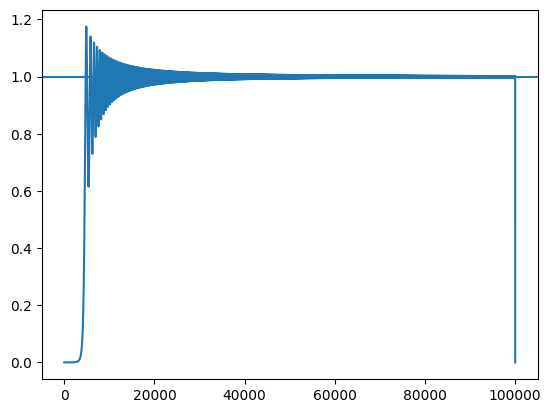

In [9]:
f = h5py.File('misc/test_0.hdf5','r')
plt.plot(f['vev'][:,0])
plt.axhline(1)
#plt.xlim(0,500)

In [ ]:
#!/usr/bin/env python

# noinspection PyUnresolvedReferences
import vtkmodules.vtkInteractionStyle
from vtkmodules.vtkCommonColor import vtkNamedColors
from vtkmodules.vtkCommonDataModel import vtkPiecewiseFunction
from vtkmodules.vtkIOLegacy import vtkStructuredPointsReader
from vtkmodules.vtkRenderingCore import (
    vtkColorTransferFunction,
    vtkRenderWindow,
    vtkRenderWindowInteractor,
    vtkRenderer,
    vtkVolume,
    vtkVolumeProperty
)
from vtkmodules.vtkRenderingVolume import vtkFixedPointVolumeRayCastMapper
# noinspection PyUnresolvedReferences
from vtkmodules.vtkRenderingVolumeOpenGL2 import vtkOpenGLRayCastImageDisplayHelper


def main():
    fileName = get_program_parameters()

    colors = vtkNamedColors()

    # This is a simple volume rendering example that
    # uses a vtkFixedPointVolumeRayCastMapper

    # Create the standard renderer, render window
    # and interactor.
    ren1 = vtkRenderer()

    renWin = vtkRenderWindow()
    renWin.AddRenderer(ren1)

    iren = vtkRenderWindowInteractor()
    iren.SetRenderWindow(renWin)

    # Create the reader for the data.
    reader = vtkStructuredPointsReader()
    reader.SetFileName(fileName)

    # Create transfer mapping scalar value to opacity.
    opacityTransferFunction = vtkPiecewiseFunction()
    opacityTransferFunction.AddPoint(20, 0.0)
    opacityTransferFunction.AddPoint(255, 0.2)

    # Create transfer mapping scalar value to color.
    colorTransferFunction = vtkColorTransferFunction()
    colorTransferFunction.AddRGBPoint(0.0, 0.0, 0.0, 0.0)
    colorTransferFunction.AddRGBPoint(64.0, 1.0, 0.0, 0.0)
    colorTransferFunction.AddRGBPoint(128.0, 0.0, 0.0, 1.0)
    colorTransferFunction.AddRGBPoint(192.0, 0.0, 1.0, 0.0)
    colorTransferFunction.AddRGBPoint(255.0, 0.0, 0.2, 0.0)

    # The property describes how the data will look.
    volumeProperty = vtkVolumeProperty()
    volumeProperty.SetColor(colorTransferFunction)
    volumeProperty.SetScalarOpacity(opacityTransferFunction)
    volumeProperty.ShadeOn()
    volumeProperty.SetInterpolationTypeToLinear()

    # The mapper / ray cast function know how to render the data.
    volumeMapper = vtkFixedPointVolumeRayCastMapper()
    volumeMapper.SetInputConnection(reader.GetOutputPort())

    # The volume holds the mapper and the property and
    # can be used to position/orient the volume.
    volume = vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)

    ren1.AddVolume(volume)
    ren1.SetBackground(colors.GetColor3d('Wheat'))
    ren1.GetActiveCamera().Azimuth(45)
    ren1.GetActiveCamera().Elevation(30)
    ren1.ResetCameraClippingRange()
    ren1.ResetCamera()

    renWin.SetSize(600, 600)
    renWin.SetWindowName('SimpleRayCast')
    renWin.Render()

    iren.Start()


def get_program_parameters():
    import argparse
    description = 'Volume rendering of a high potential iron protein.'
    epilogue = '''
    This is a simple volume rendering example that uses a vtkFixedPointVolumeRayCastMapper.
    '''
    parser = argparse.ArgumentParser(description=description, epilog=epilogue,
                                     formatter_class=argparse.RawDescriptionHelpFormatter)
    parser.add_argument('filename', help='ironProt.vtk')
    args = parser.parse_args()
    return args.filename


if __name__ == '__main__':
    main()

In [19]:
def tempcut(dtheta):
    return (dtheta - 2*np.pi)*(dtheta > np.pi) + \
           (dtheta + 2*np.pi)*(dtheta < -np.pi) + \
           (dtheta)*(dtheta < np.pi)*(dtheta > -np.pi)

def plaq(theta,i,j):
    return tempcut(np.roll(theta,1,axis=i) - theta) + \
            tempcut(np.roll(np.roll(theta,1,axis=i),1,axis=j) - np.roll(theta,1,axis=i)) + \
            tempcut(np.roll(theta,1,axis=j) - np.roll(np.roll(theta,1,axis=i),1,axis=j)) + \
            tempcut(theta - np.roll(theta,1,axis=j))

def patch_matplotlib_iface(filled,facecolors):
    def explode(data):
        size = np.array(data.shape)*2
        data_e = np.zeros(size - 1, dtype=data.dtype)
        data_e[::2, ::2, ::2] = data
        return data_e
    
    #filled = np.ones(facecolors.shape)
    filled_2 = explode(filled)
    fcolors_2 = explode(facecolors)
    
    x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
    x[0::2, :, :] += 0.05
    y[:, 0::2, :] += 0.05
    z[:, :, 0::2] += 0.05
    x[1::2, :, :] += 0.95
    y[:, 1::2, :] += 0.95
    z[:, :, 1::2] += 0.95
    
    ax = plt.figure().add_subplot(projection='3d')
    shape = facecolors.shape
    ax.voxels(x, y, z, filled_2, 
              facecolors=np.moveaxis(np.array([np.ones(filled_2.shape),
                                               np.zeros(filled_2.shape),
                                               np.zeros(filled_2.shape),fcolors_2]),0,-1),
              edgecolors=(1,0,0,0))
    #ax.set_aspect('equal')
    plt.show()
    

In [26]:
plt.scatter??

In [16]:
final = f['field'][-2]
theta = np.arctan2(final[0],final[1])
string = plaq(theta,0,1) + plaq(theta,0,2) + plaq(theta,1,2)
shape = string.shape
#color = np.moveaxis(np.array([np.ones(shape),np.zeros(shape),np.zeros(shape),np.abs(string)/(6*np.pi)]),0,-1)
color = np.abs(string)/(6*np.pi)

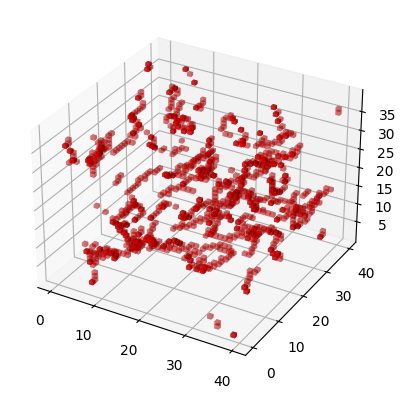

In [25]:
fc = color[:40,:40,:40]
filled = (fc > 0.2)
patch_matplotlib_iface(filled,fc)

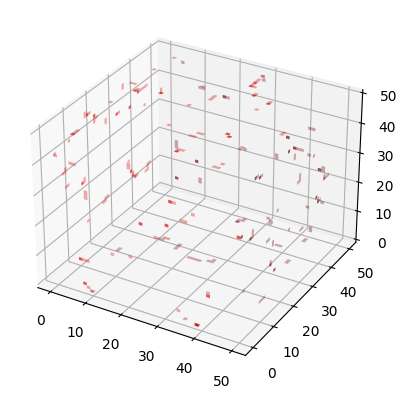

In [1184]:
size = 50
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(np.ones(shape=((size,size,size)),dtype=bool),
          edgecolors=(1,0,0,0),
          facecolors=color[:size,:size,:size])

plt.show()

In [1195]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d  # NOQA
from matplotlib.cbook import _backports
from collections import defaultdict
import types

def voxels(self, *args, **kwargs):

    if len(args) >= 3:
        # underscores indicate position only
        def voxels(__x, __y, __z, filled, **kwargs):
            return (__x, __y, __z), filled, kwargs
    else:
        def voxels(filled, **kwargs):
            return None, filled, kwargs

    xyz, filled, kwargs = voxels(*args, **kwargs)

    # check dimensions
    if filled.ndim != 3:
        raise ValueError("Argument filled must be 3-dimensional")
    size = np.array(filled.shape, dtype=np.intp)

    # check xyz coordinates, which are one larger than the filled shape
    coord_shape = tuple(size + 1)
    if xyz is None:
        x, y, z = np.indices(coord_shape)
    else:
        x, y, z = (_backports.broadcast_to(c, coord_shape) for c in xyz)

    def _broadcast_color_arg(color, name):
        if np.ndim(color) in (0, 1):
            # single color, like "red" or [1, 0, 0]
            return _backports.broadcast_to(
                color, filled.shape + np.shape(color))
        elif np.ndim(color) in (3, 4):
            # 3D array of strings, or 4D array with last axis rgb
            if np.shape(color)[:3] != filled.shape:
                raise ValueError(
                    "When multidimensional, {} must match the shape of "
                    "filled".format(name))
            return color
        else:
            raise ValueError("Invalid {} argument".format(name))

    # intercept the facecolors, handling defaults and broacasting
    facecolors = kwargs.pop('facecolors', None)
    if facecolors is None:
        facecolors = self._get_patches_for_fill.get_next_color()
    facecolors = _broadcast_color_arg(facecolors, 'facecolors')

    # broadcast but no default on edgecolors
    edgecolors = kwargs.pop('edgecolors', None)
    edgecolors = _broadcast_color_arg(edgecolors, 'edgecolors')

    # include possibly occluded internal faces or not
    internal_faces = kwargs.pop('internal_faces', False)

    # always scale to the full array, even if the data is only in the center
    self.auto_scale_xyz(x, y, z)

    # points lying on corners of a square
    square = np.array([
        [0, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [1, 0, 0]
    ], dtype=np.intp)

    voxel_faces = defaultdict(list)

    def permutation_matrices(n):
        """ Generator of cyclic permutation matices """
        mat = np.eye(n, dtype=np.intp)
        for i in range(n):
            yield mat
            mat = np.roll(mat, 1, axis=0)

    for permute in permutation_matrices(3):
        pc, qc, rc = permute.T.dot(size)
        pinds = np.arange(pc)
        qinds = np.arange(qc)
        rinds = np.arange(rc)

        square_rot = square.dot(permute.T)

        for p in pinds:
            for q in qinds:
                p0 = permute.dot([p, q, 0])
                i0 = tuple(p0)
                if filled[i0]:
                    voxel_faces[i0].append(p0 + square_rot)

                # draw middle faces
                for r1, r2 in zip(rinds[:-1], rinds[1:]):
                    p1 = permute.dot([p, q, r1])
                    p2 = permute.dot([p, q, r2])
                    i1 = tuple(p1)
                    i2 = tuple(p2)
                    if filled[i1] and (internal_faces or not filled[i2]):
                        voxel_faces[i1].append(p2 + square_rot)
                    elif (internal_faces or not filled[i1]) and filled[i2]:
                        voxel_faces[i2].append(p2 + square_rot)

                # draw upper faces
                pk = permute.dot([p, q, rc-1])
                pk2 = permute.dot([p, q, rc])
                ik = tuple(pk)
                if filled[ik]:
                    voxel_faces[ik].append(pk2 + square_rot)

    # iterate over the faces, and generate a Poly3DCollection for each voxel
    polygons = {}
    for coord, faces_inds in voxel_faces.items():
        # convert indices into 3D positions
        if xyz is None:
            faces = faces_inds
        else:
            faces = []
            for face_inds in faces_inds:
                ind = face_inds[:, 0], face_inds[:, 1], face_inds[:, 2]
                face = np.empty(face_inds.shape)
                face[:, 0] = x[ind]
                face[:, 1] = y[ind]
                face[:, 2] = z[ind]
                faces.append(face)

        poly = art3d.Poly3DCollection(faces,
            facecolors=facecolors[coord],
            edgecolors=edgecolors[coord],
            **kwargs
        )
        self.add_collection3d(poly)
        polygons[coord] = poly

    return polygons

ImportError: cannot import name '_backports' from 'matplotlib.cbook' (/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py)

In [1198]:
fc.shape

(5, 5, 5, 4)

In [1197]:
patch_matplotlib_iface(fc)

ValueError: could not broadcast input array from shape (5,5,5,4) into shape (5,5,5,7)

NameError: name '_backports' is not defined

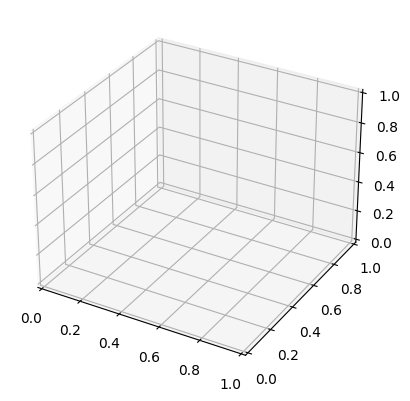

In [1194]:
size = 5
ax = plt.figure().add_subplot(projection='3d')
fc = np.zeros((size,size,size,4))
fc[:,:,:,0] = 1
fc[0,1,1,3] = 1
ax.voxels = types.MethodType(voxels, ax)
ax.voxels(np.ones(shape=((size,size,size)),dtype=bool),
          edgecolors=(1,0,0,0),
          facecolors=fc)
plt.show()

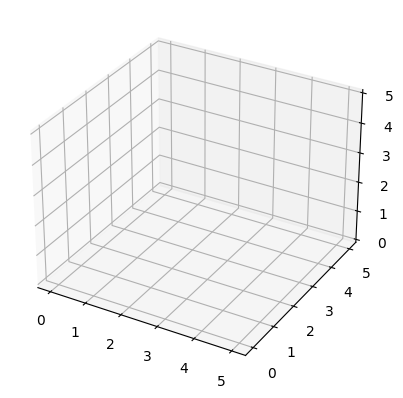

In [1190]:
size = 5
ax = plt.figure().add_subplot(projection='3d')
fc = np.zeros((size,size,size,4))
fc[:,:,:,0] = 1
fc[1,1,1,3] = 1
ax.voxels(np.ones(shape=((size,size,size)),dtype=bool),
          edgecolors=(1,0,0,0),
          facecolors=fc)
plt.show()



In [1189]:
ax.voxels??

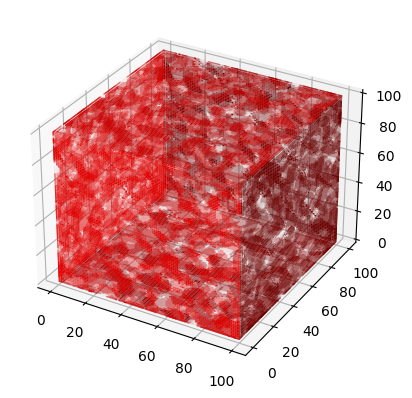

In [1121]:
import matplotlib.pyplot as plt
import numpy as np

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(np.ones(shape=((100,100,100)),dtype=bool),
          edgecolors=(1,0,0,0),
          facecolors=color[:100,:100,:100])

plt.show()

In [1109]:
ax.voxels??

In [1087]:
ax.voxels??

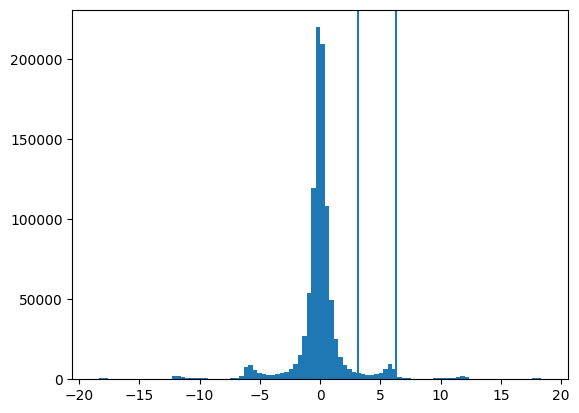

In [1081]:
plt.hist(ntheta.flatten(),bins=100)
plt.axvline(np.pi)
plt.axvline(2*np.pi)
plt.show()

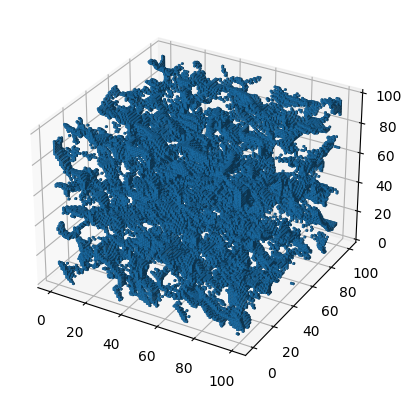

In [1082]:
import matplotlib.pyplot as plt
import numpy as np

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(ntheta > np.pi)

plt.show()

In [1067]:
from mayavi import mlab

In [1068]:
mlab.contour3d(ntheta)

ImportError: Could not import backend for traitsui.  Make sure you
        have a suitable UI toolkit like PyQt/PySide or wxPython
        installed.

In [ ]:
angle = final[]

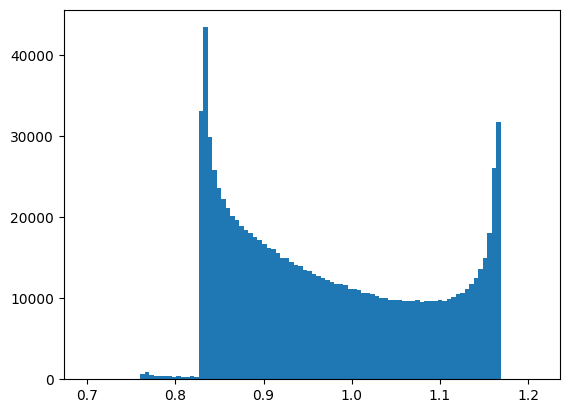

In [1042]:
plt.hist(((f['field'][-10][0]**2 + f['field'][-10][1]**2)**(1/2)).flatten(),bins=100)
plt.show()

In [713]:
f.close()
evolve_PQ(shape=(10,10,10),
          fa=1e-1,
          init_field=lambda shape: 1*np.random.random((2,10,10,10))-0.5,
          init_fieldp=lambda shape: 1*np.random.random((2,10,10,10))-0.5,
          etaini=2,
          deta=0.01,
          Nstep=2000,
          a=0.25,
          stage='PQ',
          name='test',
          logdir='/Users/joshlin/axion_cosmo/notebooks/misc',
          tolog=[("field",lambda f_fp:f_fp,1,(4,10,10,10),np.float64),
                 ("vev",lambda f_fp:np.average(np.sum(f_fp[:2]**2,axis=0)**(1/2)),1,(1,),np.float64)],
         flush=2000,)

c:0.1343813934716645
Transition expected at eta = 3.2992261018615907


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2154.08it/s]


# Evolve Tests

In [515]:
f = h5py.File('misc/test_0.hdf5','r')

In [528]:
f['field'].shape

(300001, 4, 10, 10, 10)

(array([ 55.,  59.,  87., 120., 196., 189., 106.,  90.,  60.,  38.]),
 array([-1.37759108, -1.10278903, -0.82798697, -0.55318492, -0.27838286,
        -0.00358081,  0.27122125,  0.5460233 ,  0.82082536,  1.09562741,
         1.37042947]),
 <BarContainer object of 10 artists>)

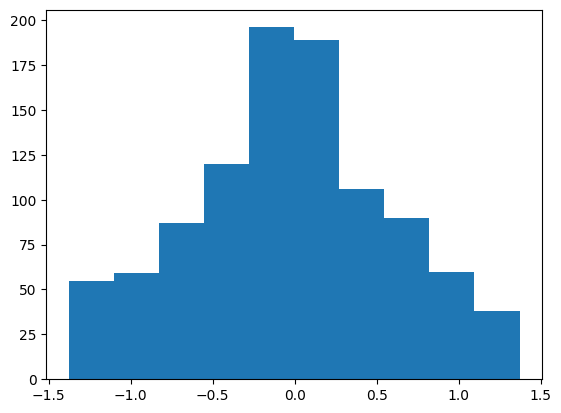

In [529]:
plt.hist(f['field'][100][0].flatten())

In [533]:
f['field'][1000:1100,0,0,0,0]

array([-1.19136060e-04, -1.25610851e-05,  1.05107431e-04,  1.09867966e-04,
       -1.04127432e-06, -1.08648902e-04, -9.98233014e-05,  1.38353345e-05,
        1.10679030e-04,  8.91680867e-05, -2.57148167e-05, -1.11261885e-04,
       -7.80659521e-05,  3.65906413e-05,  1.10475163e-04,  6.66763160e-05,
       -4.63909910e-05, -1.08408450e-04, -5.51527171e-05,  5.50611620e-05,
        1.05161454e-04,  4.36413156e-05, -6.25632188e-05, -1.00842218e-04,
       -3.22795706e-05,  6.88754678e-05,  9.55653273e-05,  2.11950992e-05,
       -7.39917674e-05, -8.94501599e-05, -1.05047209e-05,  7.79206908e-05,
        8.26191667e-05,  3.13687552e-07, -8.06845615e-05, -7.51962244e-05,
        9.28490320e-06,  8.23183810e-05,  6.73050643e-05, -1.82105136e-05,
       -8.28686658e-05, -5.90677959e-05,  2.63953973e-05,  8.23922154e-05,
        5.06035358e-05, -3.37846639e-05, -8.09548283e-05, -4.20271535e-05,
        4.03361848e-05,  7.86299855e-05,  3.34481409e-05, -4.60203522e-05,
       -7.54975185e-05, -

(0.0, 1000.0)

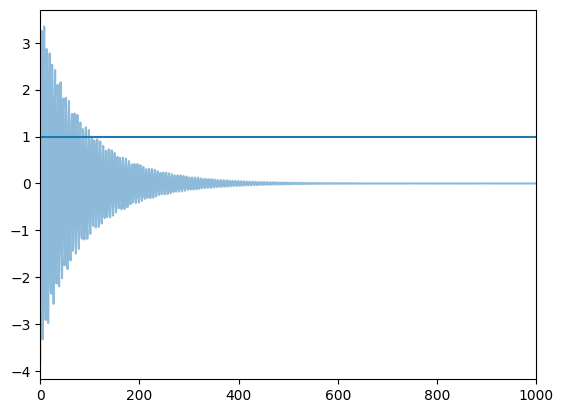

In [537]:
plt.plot(f['field'][:1000,0,0,0,0],alpha=0.5)
#plt.plot(f['vev'],alpha=0.5)
plt.axhline(1)
plt.xlim(0,1000)

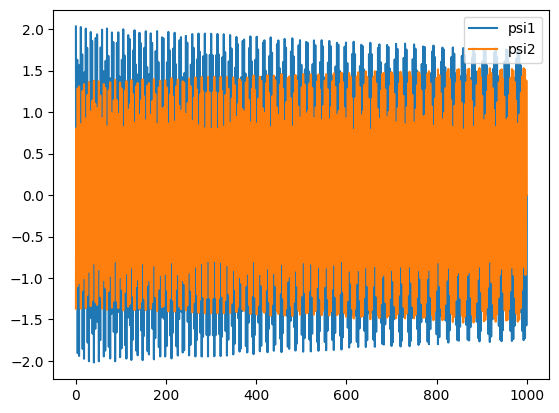

In [409]:
plt.plot(f['field'][:,0,0,0],label='psi1')
plt.plot(f['field'][:,1,0,0],label='psi2')
#plt.plot(f['field'][:,2,0]/1e3)
#plt.plot(f['field'][:,3,0]/1e3)
#plt.plot(f['field'][:,0,0]**2 + f['field'][:,1,0]**2,label='norm')
plt.legend()
#plt.xlim(0,10000)
#plt.ylim(-5,5)
#plt.ylim(-1,1)
#plt.xlim(0,1000)

In [290]:
f.close()

In [28]:
import logging
import h5py
import matplotlib.pyplot as plt

In [56]:
f = h5py.File('../tests/1_actualPQ/data/PQ_0.hdf5', 'r')

In [62]:
f.close()

In [57]:
f.keys()

<KeysViewHDF5 ['absav', 'av', 'field']>

In [58]:
f['field'].shape

(11, 4, 10, 10, 10)

In [61]:
f['field'][1,0,:,:,:]

array([[[0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949,
         0.00069949, 0.00069949, 0.00069949, 0.00069949, 0.00069949],
        [0.00069949, 0.0006

In [37]:
f.keys()

<KeysViewHDF5 ['absav', 'av', 'field']>

In [30]:
f['absav'].shape

(100001, 4)

(-2.0, 2.0)

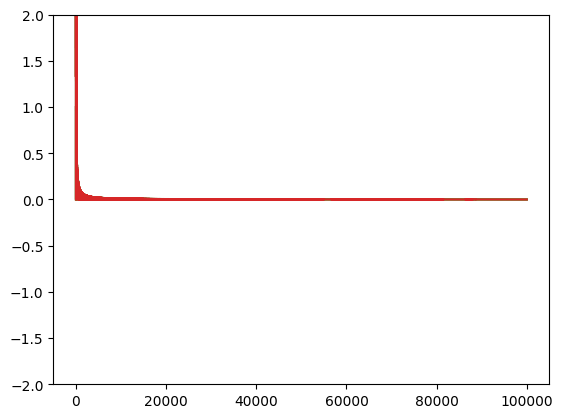

In [42]:
plt.plot(f['absav'][:,:])
plt.ylim(-2,2)

In [14]:
logging.basicConfig(filename='test')

In [ ]:
logging.

In [2]:
import pickle

In [3]:
x = pickle.load(open('../tests/1_actualPQ/data/point','rb'))

In [10]:
x['field'][-1]

(array([[[[-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          ...,
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167]],
 
         [[-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          [-0.00018167, -0.00018167, -0.00018167, ..., -0.00018167,
           -0.00018167, -0.00018167],
          ...,
          [-0

# Garbage

In [ ]:
def dummy_thermal(shape,eps=0.1):
    assert type(shape) is tuple
    return 2*eps*np.random.random((2,) + shape) - eps

def stand_dev_phi(ksq,V,T,fa):
    '''
    wrapper function to compute standard deviation of the field given wave number k
    taking lambda to 1 as mentioned in the paper
    '''

    meff2 = T**2 / 3. - fa**2
    omegak = np.sqrt(ksq + meff2)
    nk = 1./(np.exp(omegak/T) - 1)

    return nk / omegak * V

def stand_dev_phidot(ksq,V,T,fa):
    '''
    wrapper function to compute standard deviation of the time derivative of the field given wave number k
    taking lambda to 1 as mentioned in the paper
    '''
    meff2 = T**2 / 3. - fa**2
    omegak = np.sqrt(ksq + meff2)
    nk = 1./(np.exp(omegak/T) - 1)

    return nk * omegak * V

In [600]:
def t(eta,t1):
    """
    (S6)
    """
    return (eta**2)*(t1)

def t_T(gstar,T):
    """
    (S45)
    """
    return 0.3012*(gstar**(-1/2))*1.220890e22/(T**2)

def T(gstar,t):
    """
    S(45)
    """
    return (0.3012*(gstar**(-1/2))*1.220890e22/t)**(1/2)

def init_params(fa,gstar):
    """
    these ARENT where you initialize, these are at eta = 1
    """
    T1_PQ = (fa*1.220890e22/(1.660*(gstar**(1/2))))**(1/2)
    H1_PQ = H(gstar,T1_PQ)
    R1_PQ = R(gstar,T1_PQ)
    t1_PQ = t_T(gstar,T1_PQ)
    
    #mpi = 139.570
    #fpi = 130
    #mu = 2.2; md = 4.7;
    #ma = ((mpi**2*fpi**2)/fa**2)*((mu*md)/(mu+md)**2)
    ma = 5.707e3/fa
    
    Tc     = (1.68e-7*((400)**(4+6.68))/((fa**2*ma**2)))**(1/6.68)
    T1_QCD = (((1.68e-7)**(1/2)*(400)**(2+6.68/2)*1.220890e22)/(fa*1.660*gstar**(1/2)))**(1/(2+6.68/2))
    R1_QCD = R(gstar,T1_QCD)
    etac   = R(gstar,Tc)/R1_QCD
    
    return T1_PQ,H1_PQ,R1_PQ,t1_PQ,ma,Tc,T1_QCD,R1_QCD,etac